In [ ]:
#relevant installations
!apt-get install -y xvfb x11-utils 
!apt-get install x11-utils > /dev/null 2>&1
!pip install PyVirtualDisplay==2.0.* \
  PyOpenGL==3.1.* \
  PyOpenGL-accelerate==3.1.* \
  gym[box2d]==0.17.* 
!pip install pyglet
!pip install pulp
!pip install mdp

Reading package lists... Done
Building dependency tree       
Reading state information... Done
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [ ]:
#relevant imports
import gym
import numpy as np
import base64
import io
import IPython

import math, gym, copy
import operator
import random
import pickle

from gym.wrappers import Monitor
from IPython import display
from pyvirtualdisplay import Display

import numpy as np
import pulp

In [ ]:
#start the environment
env = gym.make('Pendulum-v0')
o = env.reset()

In [ ]:
#set up the discrete bins
def generate(lower_bound, upper_bound, interval):
    output = []
    while lower_bound <= upper_bound:
        output.append( int( round(lower_bound,1) + 0 ) )
        lower_bound += interval
    return output

def generate_theta(lower_bound, upper_bound, interval):
    output = []
    while lower_bound <= upper_bound:
        output.append( float( round(lower_bound,1) + 0 ) )
        lower_bound += interval
    return output

def generate_states(theta_approx, w_approx):
    states = []
    for theta in theta_approx:
        for w in w_approx:
            states.append((theta, w))
    return states

def generate_actions(a_approx):
    actions = []
    for a in a_approx:
        actions.append(a)
    return actions

In [ ]:
#discretise the state and aciton spaces using the above bins
pi = math.pi
theta_approx = generate_theta(round(-pi,1), round(pi,1), round(pi/24,1))
w_approx = generate(-8, 8, 1)
a_approx = generate(-2, 2, 1)
states = generate_states(theta_approx, w_approx)
actions = generate_actions(a_approx)

In [ ]:
#function to find theta from the x,y coordinates given from the observations
#theta is normalised as described in the environment
def find_theta(x, y):
  theta = round((np.arctan(y/x)-(pi/2)), 1)
  if theta > 3:
    theta = round((theta-3),1)
  if theta < -3.1:
    theta = round((theta+3.1),1)
  else:
    theta
  return theta

In [ ]:
#function to convert state observation to (theta, velocity) form
def get_state(obs):
  x = obs[0]
  y = obs[1]
  w = round(obs[1])
  theta = find_theta(x, y)
  state = (theta, w)
  return state

In [ ]:
#function to create an index for the states
def create_index(states):
  state_index = []
  x = -1
  for state in states:
    x = x+1
    state_index.append(x)
  return state_index
#print(state_index)

In [ ]:
#create state index
state_index = create_index(states)

#possible actions
possible_actions = actions

In [ ]:
#setting up the LP
N = len(states)
A = len(actions)
gamma = .9
v = pulp.LpVariable.dicts ("s", (range (N)))
prob = pulp.LpProblem ("pendulum", pulp.LpMinimize) #minimise
prob += sum ([v [i] for i in range (N)]) #objective function

#contraints
for s in state_index:
  for a in possible_actions:
    obs, rew, done, info = env.step(np.array([a]))
    s2 = get_state(obs)
    #fixing an exception
    if s2 == -0.0:
      s2 = 0.0
    else:
      s2 = s2
    s22 = states.index(s2)
    prob += v[s] - gamma * sum (1 * v[s22]) >= (1 * rew)

#finding the solution
prob.solve ()
print('The solution is {}'.format(pulp.LpStatus[prob.status]))

#value function
V = np.zeros (N) 
for i in range (N):
    V [i] = v [i]. varValue

#optimal policy
pi_star = np.zeros ((N), dtype=np.int64)
vduales = np.zeros ((N, A))
s = 0
a = 0

for name, c in list(prob.constraints.items()):
    vduales [s, a] = c.pi
    if a < A - 1:
        a = a + 1
    else:
        a = 0
        if s < N - 1:
            s = s + 1
        else:
            s = 0
for s in range(N):
    pi_star [s] = np.argmax (vduales [s, :])

#convert optimal policy to list
pi_star_list = pi_star.tolist()

The solution is Optimal


In [ ]:
def optimal_policy(state):
  state = get_state(env.state)
  s_index_n = states.index(state)
  a_index = pi_star_list[s_index_n]
  action = np.array([actions[a_index]])
  return action

In [ ]:
env.close
!rm ./vid/*.*

d = Display()
d.start()

env = gym.make('Pendulum-v0')
env = Monitor(env,'./vid',force=True)
o = env.reset()
rew = 0

for i in range (1000):
    o, r, d, i = env.step(optimal_policy(env.state))
    rew += r
    if d:
      env.reset()

ave_rew = rew/1000
print('The average reward over 1000 steps is {}'.format(ave_rew))

for f in env.videos:
    video = io.open(f[0], 'r+b').read()
    encoded = base64.b64encode(video)

    display.display(display.HTML(data="""
        <video alt="test" controls>
        <source src="data:video/mp4;base64,{0}" type="video/mp4" />
        </video>
        """.format(encoded.decode('ascii'))))

env.close

rm: cannot remove './vid/*.*': No such file or directory
The average reward over 1000 steps is -5.050351746273684


<bound method Monitor.close of <Monitor<TimeLimit<PendulumEnv<Pendulum-v0>>>>>

In [ ]:
 #mounting the drive
 from google.colab import drive
 import sys
 drive.mount('/content/drive')
 sys.path.insert(0,'/content/drive/MyDrive/SIT796')
 import mdp

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
  # Insert the directoryimport sys
  # Run the scripts
  !setup_colab_practical3.sh -O- | bash
  !touch .setup_complete


'\n# This code creates a virtual display to draw game images on.\n# It will have no effect if your machine has a monitor.\nif type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:\n    !bash ../xvfb start\n    os.environ[\'DISPLAY\'] = \':1\'  \n'

In [ ]:
#relevant imports
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)
from mdp import MDP

Graphviz available: True


In [ ]:
#creating transition probablity and reward dictionaries
def get_tp_rew(actions, state, env, tp, act, rew, act2, next_state_dict):
  n_state = []
  for a in actions2:
    s_str = str(state)
    a_str = str(a)  
    obs, reward2, done, info = env.step(np.array([a]))
    next_state2 = get_state(obs)
    s1_str = str(next_state2)
    n_state.append(next_state2)
    rew_str = str(reward2)
    act.update({a_str:{s1_str:1}})
    act2.update({a_str:{s1_str:rew_str}})
  tp.update({s_str:act})
  rew.update({s_str:act2})
  return tp, rew, n_state

In [ ]:
#retrieving the state value
def get_value(state):
  si = int(states.index(state))
  value_s = V[si]
  return value_s

In [ ]:
#setting up new discrete bins for the graphs
#using the previous bins made the graph unreadable
#but due to the new discrete values we loose some layering in the graph as the next step in the environment will not necessarily belong in a bin
env.close

env2 = gym.make('Pendulum-v0')

theta_approx2 = generate_theta(round(-pi,1), round(pi,1), round(pi/2,1))
w_approx2 = generate(-8, 8, 4)
a_approx2 = generate(-2, 2, 2)
states2 = generate_states(theta_approx2, w_approx2)
actions2 = generate_actions(a_approx2)

tpd = {}
act = {}
rewd = {}
act2 = {}
next_state_dict = []
state_values = {}
o_pol = {}

o2 = env2.reset()

for state in states2:
  tp, rew, next_state = get_tp_rew(actions2, state, env2, tpd, act, rewd, act2, next_state_dict)
  s_str = str(state)
  state_values.update({s_str:get_value(state)})
  for ns in next_state:
    state_values.update({s_str:get_value(ns)})
  for a in optimal_policy(state):
    a = int(a) 
    o_pol.update({s_str:str(a)})

s0 = get_state(o2)
s0_str = str((s0))

tp2, rew, next_state = get_tp_rew(actions, s0_str, env, tpd, act, rewd, act2, next_state_dict)
state_values.update({s0_str:get_value(s0)})
for ns in next_state:
  state_values.update({s_str:get_value(ns)})

mdp = MDP(tp2, rew, initial_state=s0_str)

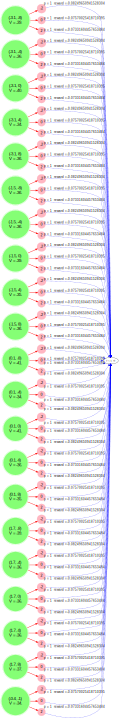

In [ ]:
#drawing the state values graph
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph_with_state_values(mdp, state_values))
    